This waveform_generator WORK

Keep working on getting it better

22:31 bilby INFO    : Waveform generator initiated with
  frequency_domain_source_model: bilby.gw.source.lal_binary_black_hole
  time_domain_source_model: None
  parameter_conversion: bilby.gw.conversion.convert_to_lal_binary_black_hole_parameters


['_PowerSpectralDensity__asd_array', '_PowerSpectralDensity__check_file_was_asd_file', '_PowerSpectralDensity__check_file_was_psd_file', '_PowerSpectralDensity__check_frequency_array_matches_density_array', '_PowerSpectralDensity__import_amplitude_spectral_density', '_PowerSpectralDensity__import_power_spectral_density', '_PowerSpectralDensity__interpolate_power_spectral_density', '_PowerSpectralDensity__power_spectral_density_interpolated', '_PowerSpectralDensity__psd_array', '_PowerSpectralDensity__validate_file_name', '__class__', '__delattr__', '__dict__', '__dir__', '__doc__', '__eq__', '__format__', '__ge__', '__getattribute__', '__gt__', '__hash__', '__init__', '__init_subclass__', '__le__', '__lt__', '__module__', '__ne__', '__new__', '__reduce__', '__reduce_ex__', '__repr__', '__setattr__', '__sizeof__', '__str__', '__subclasshook__', '__weakref__', '_asd_file', '_cache', '_psd_file', '_update_cache', 'asd_array', 'asd_file', 'frequency_array', 'from_aligo', 'from_amplitude_sp

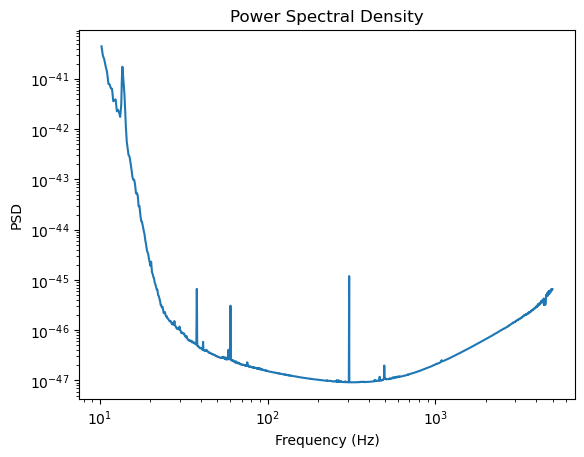

Text(0.5, 1.0, 'Amplitude Spectral Density')

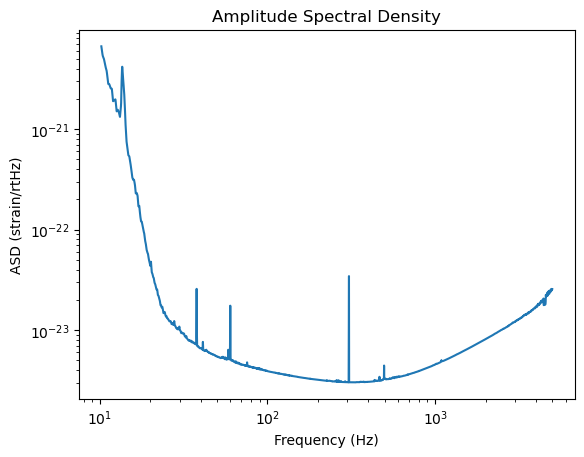

In [1]:
import bilby
import numpy as np
from bilby.gw.source import lal_binary_black_hole

# Set the parameters of the binary black hole merger
mass_1 = 36.
mass_2 = 29.
a_1 = 0.4
a_2 = 0.3
tilt_1 = 0.5
tilt_2 = 1.0
phi_12 = 1.7
phi_jl = 0.3
luminosity_distance = 2000.
theta_jn = 0.4
psi = 2.659
phase = 1.3
geocent_time = 1126259642.413
ra = 1.375
dec = -1.2108

## Define the waveform generator
waveform_generator = bilby.gw.WaveformGenerator(
    frequency_domain_source_model=lal_binary_black_hole,
    parameters={"mass_1": mass_1, "mass_2": mass_2, "a_1": a_1, "a_2": a_2,
                "tilt_1": tilt_1, "tilt_2": tilt_2, "phi_12": phi_12, "phi_jl": phi_jl,
                "luminosity_distance": luminosity_distance, "theta_jn": theta_jn, "psi": psi,
                "phase": phase, "geocent_time": geocent_time, "ra": ra, "dec": dec},
    waveform_arguments={"reference_frequency": 20},
    duration=4,
    sampling_frequency=4096)

# Generate the time-domain waveform
waveform_polarizations = waveform_generator.time_domain_strain()

# Generate the noise
minimum_frequency = 20.
maximum_frequency = 1024.
delta_f = 1.0 / waveform_generator.duration
frequency_array = np.arange(0, waveform_generator.sampling_frequency / 2, delta_f)

asd_file = "aLIGO_O4_high_asd.txt"  # Path to the ASD file
asd = bilby.gw.detector.PowerSpectralDensity.from_amplitude_spectral_density_file(asd_file)
print(dir(asd))
psd_array = asd.psd_array
# Print the PSD array
print(psd_array)
import matplotlib.pyplot as plt

# assuming you have the asd object and psd_array attribute
frequency_array = asd.frequency_array
plt.loglog(frequency_array, psd_array)
plt.xlabel('Frequency (Hz)')
plt.ylabel('PSD')
plt.title('Power Spectral Density')
plt.show()

# Plot ASD
asd_array = asd.asd_array
plt.loglog(asd.frequency_array, asd_array)
plt.xlabel('Frequency (Hz)')
plt.ylabel('ASD (strain/rtHz)')
plt.title('Amplitude Spectral Density')





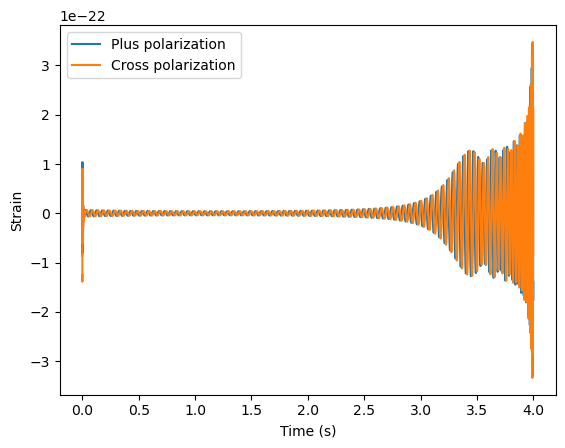

In [2]:
waveform_polarizations = waveform_generator.time_domain_strain()

# Extract the plus and cross polarization arrays and time array
plus = waveform_polarizations['plus']
cross = waveform_polarizations['cross']
time_array = waveform_generator.time_array

# Plot the strain signal
plt.plot(time_array, plus, label='Plus polarization')
plt.plot(time_array, cross, label='Cross polarization')
plt.xlabel('Time (s)')
plt.ylabel('Strain')
plt.legend()
plt.show()

In [3]:
def linear_interpolation(x, y, x_interp):
    # Initialize the interpolated x and y values
    x_interp_values = np.zeros_like(x_interp)
    y_interp_values = np.zeros_like(x_interp)

    # Find the indices of the neighboring points
    indices = np.searchsorted(x, x_interp)

    # Perform linear interpolation between the neighboring points
    for i, idx in enumerate(indices):
        if idx == 0:
            x_interp_values[i] = x[0]
            y_interp_values[i] = y[0]
        elif idx == len(x):
            x_interp_values[i] = x[-1]
            y_interp_values[i] = y[-1]
        else:
            x0, x1 = x[idx - 1], x[idx]
            y0, y1 = y[idx - 1], y[idx]
            slope = (y1 - y0) / (x1 - x0)
            x_interp_values[i] = x_interp[i]
            y_interp_values[i] = y0 + slope * (x_interp[i] - x0)

    return x_interp_values, y_interp_values


In [4]:
from scipy.interpolate import InterpolatedUnivariateSpline, interp1d

def generate_noise_from_power_spectral_density(asd, duration, sampling_frequency):
    """
    Generate noise from a given amplitude spectral density (ASD).

    Parameters
    ----------
    asd: `bilby.core.spectrum.PowerSpectralDensity` or `numpy.ndarray`
        The amplitude spectral density of the noise. If `asd` is a
        `bilby.core.spectrum.PowerSpectralDensity` object, the `psd_array`
        attribute will be used.
    duration: float
        The duration of the noise realization in seconds.
    sampling_frequency: float
        The sampling frequency of the noise realization in Hz.

    Returns
    -------
    time_array: `numpy.ndarray`
        The time series array of the generated noise.
    noise: `numpy.ndarray`
        The generated noise realization.
    """
    # If the input is an ASD object, get the PSD array
    # if isinstance(asd, PowerSpectralDensity):
    #     psd_array = asd.psd_array
    # else:
    #     psd_array = asd
    psd_array = asd.psd_array
    asd_array = asd.frequency_array
    min_psd_arr = np.min(psd_array)
    max_psd_arr = np.max(psd_array)
    print("Min psd_vals:", min_psd_arr)
    print("Max psd_vals:", max_psd_arr)
    min_asd_arr = np.min(asd_array)
    max_asd_arr = np.max(asd_array)
    print("Min asd_vals:", min_asd_arr)
    print("Max asd_vals:", max_asd_arr)
    # Check for NaN values in psd_array and asd.frequency_array
    if np.isnan(psd_array).any():
        raise ValueError("psd_array contains NaN values")
    if np.isnan(asd_array).any():
        raise ValueError("asd.frequency_array contains NaN values")

    # Check for negative values in psd_array
    if np.any(psd_array < 0):
        raise ValueError("psd_array contains negative values")
    # Check for negative values in psd_array
    if np.any(asd_array < 0):
        raise ValueError("psd_array contains negative values")
    # Calculate the normalization factor for the PSD

    df = np.mean(np.diff(asd.frequency_array))
    norm = np.sqrt(2 * df)
    print("df:",df)
    print("norm:",norm)
    # Interpolate the PSD onto the frequency values
    min_freq = np.min(asd.frequency_array)
    max_freq = np.max(asd.frequency_array)
    num_points = len(psd_array)  # Use the length of psd_array
    freqs = np.linspace(min_freq, max_freq, num_points)
    psd_interp = linear_interpolation(asd.frequency_array, psd_array, freqs)

    freqs = np.linspace(0, sampling_frequency / 2, int(duration * sampling_frequency / 2) + 1)

    frequency_array = asd.frequency_array
    plt.loglog(frequency_array, psd_array, label='Original PSD')
    plt.loglog(freqs,psd_interp(freqs) , label='Interpolated PSD')
    plt.xlabel('Frequency (Hz)')
    plt.ylabel('PSD')
    plt.title('Power Spectral Density')
    plt.legend()
    plt.show()

    # Get the frequency values for the PSD
    min_psd_interp = np.min(psd_interp(freqs))
    max_psd_interp  = np.max(psd_interp(freqs))
    print("Min psd_interp:", min_psd_interp)
    print("Max psd_interp:", max_psd_interp)
    # print min value
    arr_min_value = np.min(psd_interp(freqs) / norm)
    print(arr_min_value)
    # Add a small constant to the PSD to avoid negative or NaN values

    #psd_vals = psd_interp(freqs) / norm + 1e-44
    psd_vals = psd_interp(freqs) / norm 

    min_psd_vals = np.min(psd_vals)
    max_psd_vals = np.max(psd_vals)
    min_sqrt_psd_vals = np.min(np.sqrt(psd_vals / 2))
    max_sqrt_psd_vals = np.max(np.sqrt(psd_vals / 2))

    print("Min psd_vals:", min_psd_vals)
    print("Max psd_vals:", max_psd_vals)
    print("Min sqrt_psd_vals:", min_sqrt_psd_vals)
    print("Max sqrt_psd_vals:", max_sqrt_psd_vals)
    # Generate a random vector of normal distributed noise
    rand_vec = np.random.randn(len(psd_vals))

    # Get the Fourier transform of the noise
    print(psd_vals)
    noise_ft = rand_vec * np.sqrt(psd_vals / 2)

    # Set the Nyquist frequency to zero
    if len(noise_ft) % 2 == 0:
        noise_ft[-1] = 0
    else:
        noise_ft[-1] *= np.sqrt(2)

    # Inverse Fourier transform the noise
    noise = np.fft.irfft(noise_ft)

    # Truncate the noise to the requested duration
    noise = noise[:int(duration * sampling_frequency)]

    # Generate the time array
    time_array = np.arange(0, duration, 1 / sampling_frequency)

    return time_array, noise


this version is with adding a value at 0

In [5]:
from scipy.interpolate import interp1d
import numpy as np
import matplotlib.pyplot as plt

def generate_noise_from_power_spectral_density(asd, duration, sampling_frequency):
    """
    Generate noise from a given amplitude spectral density (ASD).

    Parameters
    ----------
    asd: `bilby.core.spectrum.PowerSpectralDensity` or `numpy.ndarray`
        The amplitude spectral density of the noise. If `asd` is a
        `bilby.core.spectrum.PowerSpectralDensity` object, the `psd_array`
        attribute will be used.
    duration: float
        The duration of the noise realization in seconds.
    sampling_frequency: float
        The sampling frequency of the noise realization in Hz.

    Returns
    -------
    time_array: `numpy.ndarray`
        The time series array of the generated noise.
    noise: `numpy.ndarray`
        The generated noise realization.
    """

    # Extract the PSD array and frequency array from asd

    psd_array = asd.psd_array
    frequency_array = asd.frequency_array


    # Check for NaN values in psd_array and frequency_array
    if np.isnan(psd_array).any():
        raise ValueError("psd_array contains NaN values")
    if np.isnan(frequency_array).any():
        raise ValueError("frequency_array contains NaN values")

    # Check for negative values in psd_array and frequency_array
    if np.any(psd_array < 0):
        raise ValueError("psd_array contains negative values")
    if np.any(frequency_array < 0):
        raise ValueError("frequency_array contains negative values")

    # Calculate the normalization factor for the PSD
    df = np.mean(np.diff(frequency_array))
    norm = np.sqrt(2 * df)

    # Interpolate the PSD onto the common frequency range
    common_freqs = np.linspace(0, sampling_frequency / 2, int(duration * sampling_frequency / 2) + 1)
    desired_value = 5e-41  # ??

# Create a new interpolation function with the desired value at 0 Hz
    frequency_array_with_zero = np.concatenate(([0], frequency_array))
    psd_array_with_zero = np.concatenate(([desired_value], psd_array))
    psd_interp = interp1d(frequency_array_with_zero, psd_array_with_zero / norm, kind='linear', bounds_error=False, fill_value=0)

    #min_psd_interp = np.min(psd_interp(common_freqs))
    #max_psd_interp  = np.max(psd_interp(common_freqs))
    #print("Min psd_interp:", min_psd_interp)
    #print("Max psd_interp:", max_psd_interp)
    ##
    print(type(psd_interp))

    # Plot the original and interpolated PSDs
    plt.loglog(frequency_array, psd_array, label='Original PSD')
    plt.loglog(common_freqs, psd_interp(common_freqs) * norm, label='Interpolated PSD')
    plt.yscale('linear')  # Set y-axis scale to linear
    
    plt.xlabel('Frequency (Hz)')
    plt.ylabel('PSD')
    plt.title('Power Spectral Density')
    plt.legend()
    plt.show()
    # Add a point at (0, value)
   

    # Plot the original and interpolated PSDs
    plt.loglog(frequency_array, psd_array, label='Original PSD')
    plt.loglog(common_freqs, psd_interp(common_freqs) * norm, label='Interpolated PSD')
    plt.yscale('linear')  # Set y-axis scale to linear

    # Set the x-axis limits to 100 Hz and 1000 Hz
    plt.xlim(10, 11)

    plt.xlabel('Frequency (Hz)')
    plt.ylabel('PSD')
    plt.title('Power Spectral Density')
    plt.legend()
    plt.show()

    # Generate random noise
    rand_vec = np.random.randn(len(common_freqs))
    noise_ft = rand_vec * np.sqrt(psd_interp(common_freqs) / 2)

    # Set the Nyquist frequency to zero
    if len(noise_ft) % 2 == 0:
        noise_ft[-1] = 0
    else:
        noise_ft[-1] *= np.sqrt(2)

    # Inverse Fourier transform the noise
    noise = np.fft.irfft(noise_ft)

    # Truncate the noise to the requested duration
    noise = noise[:int(duration * sampling_frequency)]

    # Generate the time array
    time_array = np.arange(0, duration, 1 / sampling_frequency)

    return time_array, noise


orignal version-

In [ ]:
from scipy.interpolate import interp1d
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import UnivariateSpline
from scipy.interpolate import InterpolatedUnivariateSpline



def generate_noise_from_power_spectral_density(asd, duration, sampling_frequency):
    """
    Generate noise from a given amplitude spectral density (ASD).

    Parameters
    ----------
    asd: `bilby.core.spectrum.PowerSpectralDensity` or `numpy.ndarray`
        The amplitude spectral density of the noise. If `asd` is a
        `bilby.core.spectrum.PowerSpectralDensity` object, the `psd_array`
        attribute will be used.
    duration: float
        The duration of the noise realization in seconds.
    sampling_frequency: float
        The sampling frequency of the noise realization in Hz.

    Returns
    -------
    time_array: `numpy.ndarray`
        The time series array of the generated noise.
    noise: `numpy.ndarray`
        The generated noise realization.
    """

    # Extract the PSD array and frequency array from asd

    psd_array = asd.psd_array
    frequency_array = asd.frequency_array


    # Check for NaN values in psd_array and frequency_array
    if np.isnan(psd_array).any():
        raise ValueError("psd_array contains NaN values")
    if np.isnan(frequency_array).any():
        raise ValueError("frequency_array contains NaN values")

    # Check for negative values in psd_array and frequency_array
    if np.any(psd_array < 0):
        raise ValueError("psd_array contains negative values")
    if np.any(frequency_array < 0):
        raise ValueError("frequency_array contains negative values")

    # Calculate the normalization factor for the PSD
    df = np.mean(np.diff(frequency_array))
    norm = np.sqrt(2 * df)

    # Interpolate the PSD onto the common frequency range
    common_freqs = np.linspace(frequency_array[0], sampling_frequency / 2, int(duration * sampling_frequency / 2) + 1)
    #spline = UnivariateSpline(frequency_array, psd_array / norm, s=0)  # Here we use the UnivariateSpline for interpolation
    spline = InterpolatedUnivariateSpline(frequency_array, psd_array / norm, k=1)

    psd_interp = spline

    #Add a point at 0hz for test
    #psd_interp(frequency_array[0]) = value

    #min_psd_interp = np.min(psd_interp(common_freqs))
    #max_psd_interp  = np.max(psd_interp(common_freqs))
    #print("Min psd_interp:", min_psd_interp)
    #print("Max psd_interp:", max_psd_interp)
    ##

    # Plot the original and interpolated PSDs
    plt.loglog(frequency_array, psd_array, label='Original PSD')
    #print(frequency_array[0])
    #print(psd_array[0])
    plt.loglog(common_freqs, psd_interp(common_freqs) * norm, label='Interpolated PSD')
    plt.yscale('linear')  # Set y-axis scale to linear
    plt.xlim(10, 15)

    plt.xlabel('Frequency (Hz)')
    plt.ylabel('PSD')
    plt.title('Power Spectral Density')
    plt.legend()
    plt.show()
    # Add a point at (0, value)
   

    # Plot the original and interpolated PSDs
    plt.loglog(frequency_array, psd_array, label='Original PSD')
    plt.loglog(common_freqs, psd_interp(common_freqs) * norm, label='Interpolated PSD')
    plt.yscale('linear')  # Set y-axis scale to linear

    # Set the x-axis limits to 100 Hz and 1000 Hz
    plt.xlim(10, 11)

    plt.xlabel('Frequency (Hz)')
    plt.ylabel('PSD')
    plt.title('Power Spectral Density')
    plt.legend()
    plt.show()

    # Generate random noise
    rand_vec = np.random.randn(len(common_freqs))
    noise_ft = rand_vec * np.sqrt(psd_interp(common_freqs) / 2)

    # Set the Nyquist frequency to zero
    if len(noise_ft) % 2 == 0:
        noise_ft[-1] = 0
    else:
        noise_ft[-1] *= np.sqrt(2)

    # Inverse Fourier transform the noise
    noise = np.fft.irfft(noise_ft)

    # Truncate the noise to the requested duration
    noise = noise[:int(duration * sampling_frequency)]

    # Generate the time array
    time_array = np.arange(0, duration, 1 / sampling_frequency)

    return time_array, noise


<class 'scipy.interpolate.interpolate.interp1d'>


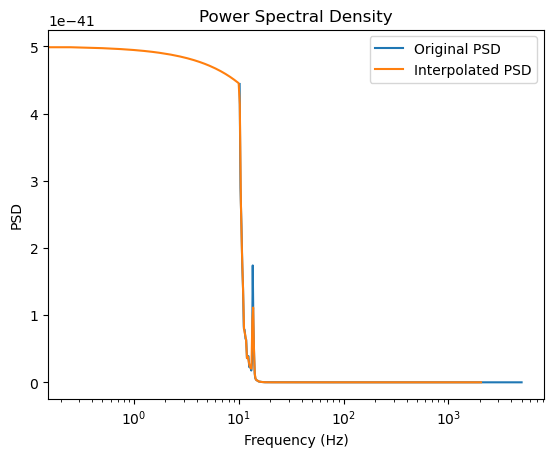

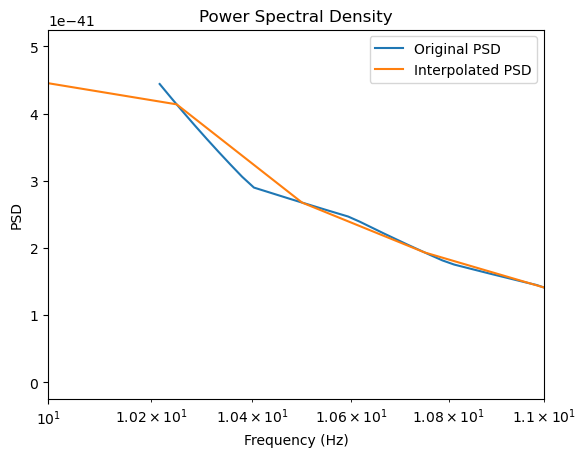

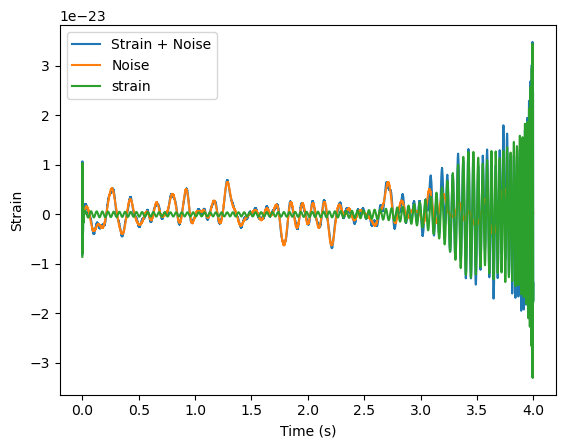

16384


In [6]:
# Generate noise from the ASD
time_array1, noise = generate_noise_from_power_spectral_density(asd, waveform_generator.duration, waveform_generator.sampling_frequency)
plus_low = plus
plus_low = plus_low /10  # Add 10^-10 to the first element of the plus array
plt.plot(time_array1, plus_low + noise, label='Strain + Noise')
plt.plot(time_array1, noise, label='Noise')
plt.plot(time_array1, plus_low, label='strain')
plt.xlabel('Time (s)')
plt.ylabel('Strain')
plt.legend()
plt.show()
print(len(time_array1))
#10/6/23

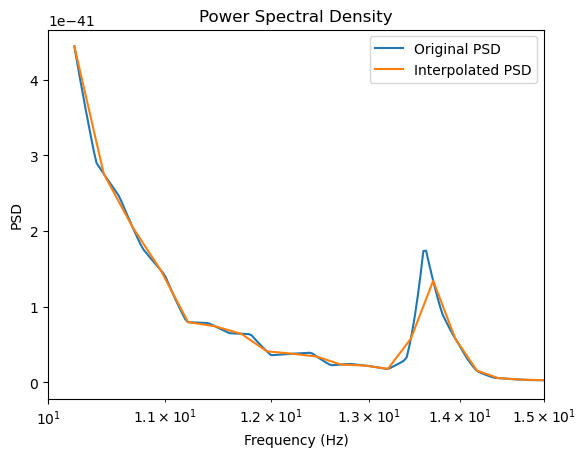

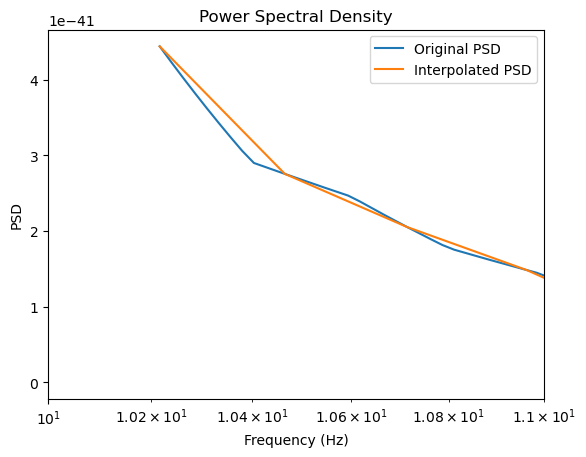

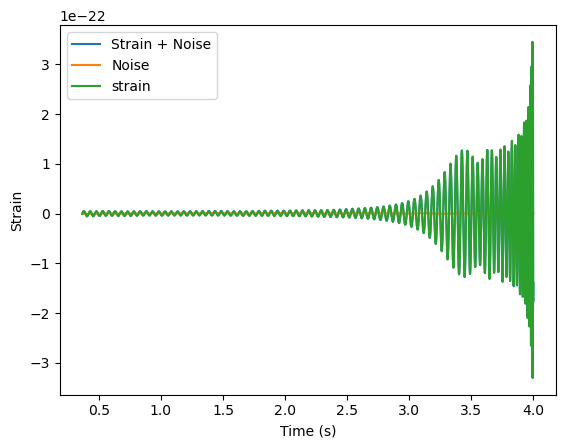

16384


In [ ]:
time_array1, noise = generate_noise_from_power_spectral_density(asd, waveform_generator.duration, waveform_generator.sampling_frequency)
start_index = 1500  # Specify the index from where you want to start plotting

# Slice the time array, plus, and noise arrays from the start_index
time_array_sliced = time_array[start_index:]
plus_sliced = plus[start_index:]
noise_sliced = noise[start_index:]
# Generate noise from the ASD
plt.plot(time_array_sliced, plus_sliced + noise_sliced, label='Strain + Noise')
plt.plot(time_array_sliced, noise_sliced, label='Noise')
plt.plot(time_array_sliced, plus_sliced, label='strain')
plt.xlabel('Time (s)')
plt.ylabel('Strain')
plt.legend()
plt.show()
print(len(time_array1))

Trying Ofek suugestion - linear plotting 

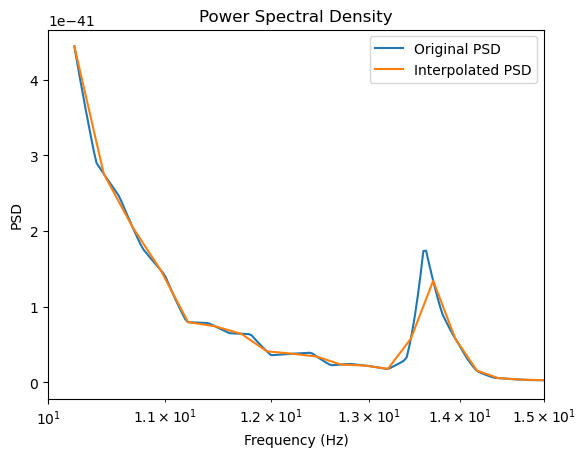

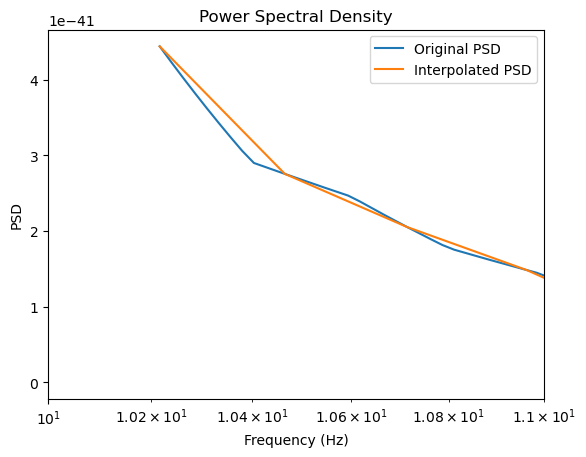

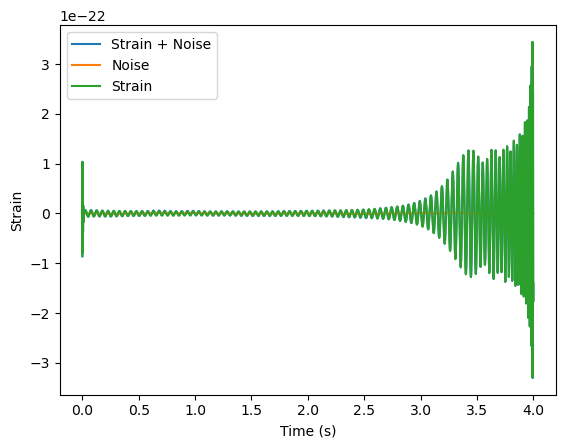

16384


In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Assuming you have the time array, plus (strain waveform), and noise generated

# Generate noise from the ASD
time_array1, noise = generate_noise_from_power_spectral_density(asd, waveform_generator.duration, waveform_generator.sampling_frequency)

#plus[0] = plus[0] / 10  # Decrease the power of the signal by 10

# Plot the graph on a linear scale
plt.plot(time_array1, plus + noise, label='Strain + Noise', linestyle='-')
plt.plot(time_array1, noise, label='Noise', linestyle='-')
plt.plot(time_array1, plus, label='Strain', linestyle='-')
plt.xlabel('Time (s)')
plt.ylabel('Strain')
plt.legend()
plt.show()

print(len(time_array1))


In [ ]:
import bilby
print(bilby.__version__)

1.4.0
